# Analysis of  StarTracker Pointing - Repeatability 

Full test description at: https://sitcomtn-065.lsst.io/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Insert here the observation information. 

In [2]:
# Observation Deck
# name of the json file should be: 'startracker_YYYY-MM-DD.json'
# 'YYYY-MM-DD': [[seq_number_0, seq_number_1],[seq_number_2, seq_number_3]]

obsDeck = {'2023-03-09':[ [600,646],  [646,946],  [949,982], [983,1115]],
           '2023-03-17':[ [292,858] ],
           '2023-03-22':[[590, 1200]]
          }

### Process the Data

- The groups are images that share the same target RA,DEC. The function `get_groups` finds them by selecting the images with less than 30 arcec appart.

- The snakes are the full set of exposures of a circle of 3.5 deg radius. The function `get_snakes` groups the circles with a point difference than 7deg. I choose this large offset because I use an eucledi

In [11]:
from helper import read_rubintv, get_groups, get_snakes, filter_sequences, filter_groups

def process_data(date, sequences):
    # read data
    df = read_rubintv(date)
    
    # select sequences
    data = filter_sequences(df, sequences)
    
    # group the three images taken in a row
    data = get_groups(data)
    
    # select only groups w/ 3 or 4 images
    data, ngroups = filter_groups(data)
    
    # get snakes
    data = get_snakes(data)
    
    nsnakes = np.unique(data['snakes']).size
    print('Number of Snakes: %i'%nsnakes)
    
    return data

In [12]:
datas = dict().fromkeys(obsDeck.keys())
for date, seq in zip(obsDeck.keys(), obsDeck.values()):
    print('Processing Data: %s'%date)
    print('sequences: %i-%i'%(np.min(seq),np.max(seq)))
    data = process_data(date, seq)
    datas[date] = data
    print()

Processing Data: 2023-03-09
sequences: 600-1115
Number of Groups: 162
Number of Snakes: 14

Processing Data: 2023-03-17
sequences: 292-858
Number of Groups: 183
Number of Snakes: 17

Processing Data: 2023-03-22
sequences: 590-1200
Number of Groups: 123
Number of Snakes: 11



### Check The Snakes

In [13]:
### check snakes
def plot_check_snakes(data, date):
    plt.figure()
    data['Calculated Ra wide'].plot(color='lightgray')
    plt.scatter(data['seq_num'] ,data['Calculated Ra wide'], 
               c=data['snakes'], cmap='tab20_r')
    #plt.scatter(data['Ra'],data['Dec'], c=data['snakes'], cmap='tab20c_r')

    plt.title('Settles - Snakes - %s'%date, fontsize=16)
    plt.xlabel('Ra', fontsize=16)
    #plt.ylabel('Dec', fontsize=16)
    plt.xlabel('Seq Number', fontsize=16)
    plt.savefig('figures/check_snakes_ra_%s.png'%date,dpi=100)

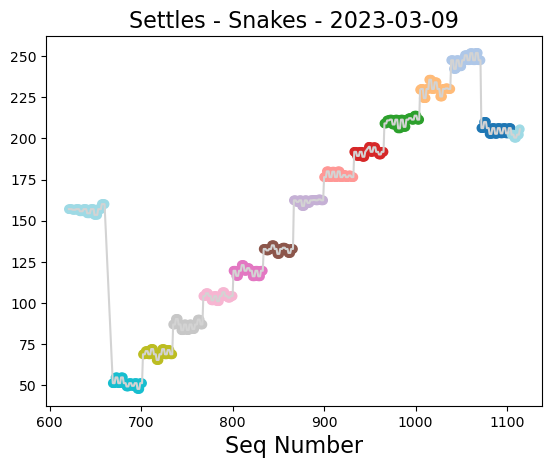

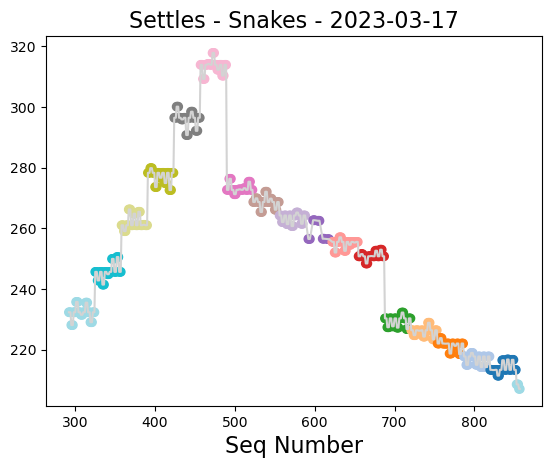

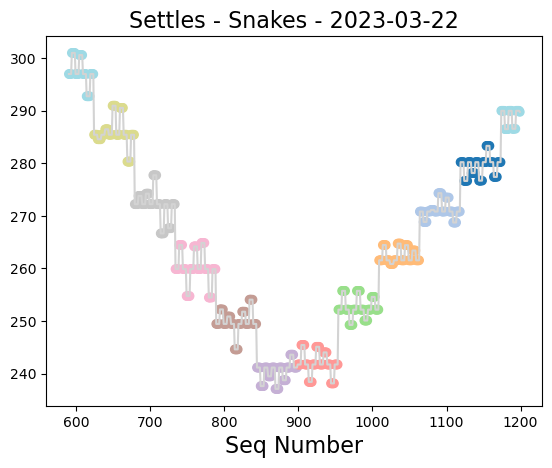

In [14]:
for date, data in zip(datas.keys(), datas.values()):
    plot_check_snakes(data, date)

## Residual Without Drift

The residual is the calculated coordinate subtracted by the mean of three images in a row. In the code language, I do the mean over each group of images.

In [10]:
def get_residual(ycol, df, keys):
    yvec = df[ycol].to_numpy()
    res = np.zeros_like(yvec)
    for ix in keys:
        res[ix] = (yvec[ix]-np.mean(yvec[ix]))*3600
    return res

def get_baseline(ycol, df, keys):
    yvec = df[ycol].to_numpy()
    base = np.zeros_like(yvec)
    for ix in keys:
        base[ix] = np.mean(yvec[ix])
    return base

def generate_data_wo_drift(data, date):
    # compute residuals over three images
    snakes = data['groups'].to_numpy()
    keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]

    # radec quantities
    res_ra = get_residual('Calculated Ra wide', data, keys)
    res_dec = get_residual('Calculated Dec wide', data, keys)
    
    base_ra = get_baseline('Calculated Ra wide', data, keys)
    base_dec = get_baseline('Calculated Dec wide', data, keys)
    
    # az/alt quantities
    res_az = get_residual('Calculated Az wide', data, keys)
    res_alt = get_residual('Calculated Alt wide', data, keys)
    
    base_az = get_baseline('Calculated Az wide', data, keys)
    base_alt = get_baseline('Calculated Alt wide', data, keys)
    
    # put in a dataframe
    myvars = res_ra, res_dec, res_az, res_alt, base_ra, base_dec, base_az, base_alt, snakes
    cols = ['Res ra', 'Res dec', 'Res az', 'Res alt','Base Ra', 'Base Dec', 'Base Az', 'Base Alt', 'Snakes']
    mydict = dict().fromkeys(cols)
    for i,col in enumerate(cols):
        mydict[col] = myvars[i]
    
    # save output
    out = pd.DataFrame(mydict)
    out.to_csv('tmp/repeatability_wo_drift_%s.csv'%date)
    print('File saved: %s'%('tmp/repeatability_wo_drift_%s.csv'%date))

In [10]:
for date, data in zip(datas.keys(), datas.values()):
    generate_data_wo_drift(data, date)

File saved: tmp/repeatability_wo_drift_2023-03-09.csv
File saved: tmp/repeatability_wo_drift_2023-03-17.csv


## Residual With Drift

The residual is computed by subtracting the first exposure of the circle. In the code language, I group by the snakes, then I subtract the first element of the sequence.

In [11]:
# from helper import get_residual_2, get_baseline_2
def get_residual_2(ycol, df, keys):
    yvec = df[ycol].to_numpy()
    res = np.zeros_like(yvec)
    for ix in keys:
        res[ix] = (yvec[ix]-yvec[ix][0])*3600
    return res

def get_baseline_2(ycol, df, keys):
    yvec = df[ycol].to_numpy()
    base = np.zeros_like(yvec)
    for ix in keys:
        base[ix] = yvec[ix][0]
    return base

def generate_data_w_drift(data, date):
    # compute residuals over three images
    snakes = data['snakes'].to_numpy()
    keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]

    # radec quantities
    res_ra = get_residual_2('Calculated Ra wide', data, keys)
    res_dec = get_residual_2('Calculated Dec wide', data, keys)
    
    base_ra = get_baseline_2('Calculated Ra wide', data, keys)
    base_dec = get_baseline_2('Calculated Dec wide', data, keys)
    
    # az/alt quantities
    res_az = get_residual_2('Calculated Az wide', data, keys)
    res_alt = get_residual_2('Calculated Alt wide', data, keys)
    
    base_az = get_baseline_2('Calculated Az wide', data, keys)
    base_alt = get_baseline_2('Calculated Alt wide', data, keys)
    
    # get time
    base_utc = get_baseline_2('UTC', data, keys)
    utc = data['UTC']
    dT = (utc - base_utc).to_numpy().astype('timedelta64[s]').astype(np.int32)

    # put in a dataframe
    myvars = dT, res_ra, res_dec, res_az, res_alt, base_ra, base_dec, base_az, base_alt, snakes, utc
    cols = ['dT', 'Res ra', 'Res dec', 'Res az', 'Res alt','Base Ra', 'Base Dec', 'Base Az', 'Base Alt', 'Snakes', 'UTC']
    mydict = dict().fromkeys(cols)
    for i,col in enumerate(cols):
        mydict[col] = myvars[i]
    
    # save output
    out = pd.DataFrame(mydict)
    out.to_csv('tmp/repeatability_w_drift_%s.csv'%date)
    print('File saved: %s'%('tmp/repeatability_w_drift_%s.csv'%date))

In [12]:
for date, data in zip(datas.keys(), datas.values()):
    generate_data_w_drift(data, date)

File saved: tmp/repeatability_w_drift_2023-03-09.csv
File saved: tmp/repeatability_w_drift_2023-03-17.csv
